# Image Augmentation

Here we will cover the steps to perform image augemntation in Pytorch.

In [1]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-etjy_k2s
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-etjy_k2s
     |████████████████████████████████| 48.3 MB 1.7 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.0-py3-none-any.whl size=114151 sha256=f5ac1d1d61248e1c6a2a23ecae57d77e9767d4bb9aef547480451da23c65810a
  Stored in directory: /tmp/pip-ephem-wheel-cache-mhdt2o3s/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
!pip install "opencv-python-headless<4.3"
!pip install PyYAML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.1 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
import numpy as np
import torch
from PIL import Image

from torchvision import transforms as tr
# from torchvision.transfroms import Compose

In [8]:
import albumentations as A
import cv2
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# !git clone https://github.com/ultralytics/yolov5  # clone
# %cd yolov5
# %pip install -qr requirements.txt  # install

In [6]:
# Load the drive to access the images and annotations
from google.colab import drive
drive.mount('/content/gdrive')

# reduce the path of the drive
def driveSymboLink():
  # this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
  !ln -s /content/gdrive/My\ Drive/ /mydrive
  # !ls /mydrive

driveSymboLink()

Mounted at /content/gdrive


In [9]:
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [10]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

WDIR='/mydrive/MIDS/W210/Animal_Identification'

# Create random augmentations
Here we set the augmentations to be performed to the cropped and resized leopard images.

# Thought process

- We find every class folder (e. g. leop_99), the selected class has a chance of 30% to be augmented.
- For individuals that were augmented, we sample 10 images with replacement.
  - Individuals with plenty of data, will not have a huge augmentation impact.
  - Individuals with few images will have a much larger impact. For example, if one leopard had 3 images, the set would grow to 13. But, if one has a 100, then it would grow to 110.
- Then, we apply a random augmentation from the pipeline adding blur, translation, noise, saturation, etc. We save the augmented image in the same folder of the individual leopard.

In [ ]:
# Path to cropped and resized images in the train folder
pathToClass=WDIR+'/datasets/processed/leopard/train/_resized'
classesFolder=os.listdir(pathToClass)
augmentationsList=[]

for individual in classesFolder:
  # print(individual)

  if random.random() > 0.3:
    continue
  # print(pathToClass+'/'+individual)
  imgPath=pathToClass+'/'+individual

  count_images=len(os.listdir(imgPath))
  listImgs=(os.listdir(imgPath))

  print(f"Individual {individual} has {count_images} images.")

  random.seed(55)

  for ix,img in enumerate(random.choices(listImgs, k=10)):

    # print(imgPath+'/'+img)
    tmpPath=imgPath+'/'+img

    image = cv2.imread(tmpPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # print original
    # print("Original image")
    # visualize(image)

    #transformation
    transform = A.Compose([
                        A.OneOf([
                            A.GaussNoise(),
                            # A.RandomSunFlare()
                        ], p=0.8),
                        A.OneOf([
                            A.MotionBlur(p=.2),
                            A.MedianBlur(blur_limit=3, p=0.1),
                            A.Blur(blur_limit=3, p=0.1),
                        ], p=0.3),
                        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=80, p=0.5),
                        A.OneOf([
                              A.OpticalDistortion(p=0.3),
                              A.GridDistortion(p=.1),
                              A.PiecewiseAffine(p=0.3),
                        ], p=0.3),
                        A.OneOf([
                            A.CLAHE(clip_limit=2),
                            A.Sharpen(),
                            A.Emboss(),
                            A.RandomBrightnessContrast(),           
                        ], p=0.3),
                        A.HueSaturationValue(p=0.3),
                        A.Perspective(p=0.2)
                        ])  # transforms

    augmented_image = transform(image=image)['image']

    # print("Augmented image")

    # visualize(augmented_image)

    new_name=tmpPath[:-4]+'a'+str(ix)+'.jpg'
    print(new_name)
    # keep track of augmented images
    augmentationsList.append(new_name)

    # save the augmented image file
    cv2.imwrite(new_name, augmented_image)




# imgs=os.listdir(pathToClass+classFolder[0])
# resizedCroppedImg=os.listdir(pathToClass+classFolder[0]+'/'+img[0])

Individual leop_101 has 2 images.
/mydrive/MIDS/W210/Animal_Identification/datasets/processed/leopard/train/_resized/leop_101/leop_101_002283a0.jpg
/mydrive/MIDS/W210/Animal_Identification/datasets/processed/leopard/train/_resized/leop_101/leop_101_002284a1.jpg
/mydrive/MIDS/W210/Animal_Identification/datasets/processed/leopard/train/_resized/leop_101/leop_101_002283a2.jpg
/mydrive/MIDS/W210/Animal_Identification/datasets/processed/leopard/train/_resized/leop_101/leop_101_002284a3.jpg
/mydrive/MIDS/W210/Animal_Identification/datasets/processed/leopard/train/_resized/leop_101/leop_101_002284a4.jpg
/mydrive/MIDS/W210/Animal_Identification/datasets/processed/leopard/train/_resized/leop_101/leop_101_002284a5.jpg
/mydrive/MIDS/W210/Animal_Identification/datasets/processed/leopard/train/_resized/leop_101/leop_101_002283a6.jpg
/mydrive/MIDS/W210/Animal_Identification/datasets/processed/leopard/train/_resized/leop_101/leop_101_002283a7.jpg
/mydrive/MIDS/W210/Animal_Identification/datasets/proc

In [ ]:
# Write a reference file for augemented images
with open(WDIR+'/datasets/processed/leopard/train/_resized/augmented_leopards.txt','w') as al:
  for item in augmentationsList:
    al.write(item+"\n")

In [ ]:
print(f"We augmented: {len(augmentationsList)} images.")

We augmented: 1060 images.


## Revert the state
Here is the code to remove all of the augmented images.

In [ ]:
# Delete all images
filePath=WDIR+'/datasets/processed/leopard/train/_resized/augmented_leopards.txt'
with open(filePath, 'r') as f:
  lines=f.readlines()

for line in lines:
  try:
    os.remove(line[:-1])
  except:
    pass

# Playground: Try out other transformation
If you want to modify the transformation pipeline, you can try out the pipeline below with a single image.

See all transformations here: [Albumentations list](https://albumentations.ai/docs/getting_started/transforms_and_targets/)

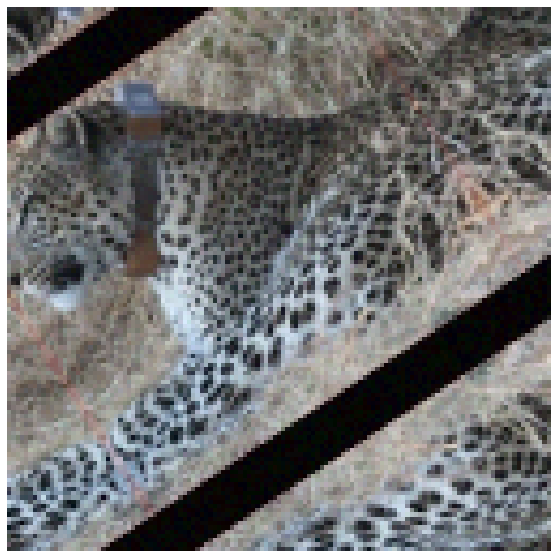

In [ ]:
pathTestImg=WDIR+'/datasets/processed/leopard/train/_resized/leop_0/leop_0_001442.jpg'
image = cv2.imread(pathTestImg)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = A.Compose([
                A.OneOf([
                    A.GaussNoise(),
                    A.RandomSunFlare()
                ], p=0.4),
                A.OneOf([
                    A.MotionBlur(p=.2),
                    A.MedianBlur(blur_limit=3, p=0.1),
                    A.Blur(blur_limit=3, p=0.1),
                ], p=0.3),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=80, p=0.5),
                A.OneOf([
                    A.OpticalDistortion(p=0.3),
                    A.GridDistortion(p=.1),
                    A.PiecewiseAffine(p=0.3),
                ], p=0.3),
                A.OneOf([
                    A.CLAHE(clip_limit=2),
                    A.Sharpen(),
                    A.Emboss(),
                    A.RandomBrightnessContrast(),           
                ], p=0.3),
                A.HueSaturationValue(p=0.3),
                A.Perspective(p=0.2)
                ])  # transforms

augmented_image = transform(image=image)['image']

visualize(augmented_image)

If you want to change the transformations in the detection model, please let me know to run the model accordingly - Caro.

True

# DA for YOLOv5 Detection
Yolov5 has integrated Albumtations into their training script.
The `utils/augmentations.py` has been altered to include the transformations pipeline as follows:

```
T = [
                A.OneOf([
                    A.GaussNoise(),
                    A.RandomSunFlare()
                ], p=0.4),
                A.OneOf([
                    A.MotionBlur(p=.2),
                    A.MedianBlur(blur_limit=3, p=0.1),
                    A.Blur(blur_limit=3, p=0.1),
                ], p=0.3),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=80, p=0.5),
                A.OneOf([
                    A.OpticalDistortion(p=0.3),
                    A.GridDistortion(p=.1),
                    A.PiecewiseAffine(p=0.3),
                ], p=0.3),
                A.OneOf([
                    A.CLAHE(clip_limit=2),
                    A.Sharpen(),
                    A.Emboss(),
                    A.RandomBrightnessContrast(),           
                ], p=0.3),
                A.HueSaturationValue(p=0.3),
                A.Perspective(p=0.2)
                ]  # transforms

```

Additionally, the hyperparameters configuration `data/hyp/hyp.scratch-low.yaml` has been override to omit augmentations by default.

In [17]:
%cd /content/gdrive/MyDrive/MIDS/W210/Animal_Identification/yolov5

/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/yolov5


In [ ]:
# data yaml file
# dataPath=WDIR+'/yolov5/data/custom.yaml'
hyp_aug=WDIR+'/yolov5/data/hyps/hyp.scratch-med.yaml'
#'/yolov5/data/hyps/hyp.scratch-low.yaml'


In [ ]:
# data yaml from 270
dataPath='/content/leopard_h_f_270-2/data.yaml'

In [ ]:
# pathToImgF=WDIR+'/datasets/leopard/train/images/'
# imgs=os.listdir(pathToImgF)

# print(pathToImgF+imgs[0])

## Baseline with no augmentation no negatives

In [ ]:
!python train.py --img 640 --batch 16 --epochs 150 --data $dataPath --weights yolov5s.pt --cache --hyp $hyp_aug --name "det-no-augmentation"

train: weights=yolov5s.pt, cfg=, data=/mydrive/MIDS/W210/Animal_Identification/yolov5/data/custom.yaml, hyp=/mydrive/MIDS/W210/Animal_Identification/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=det-no-augmentation, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2022-6-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.

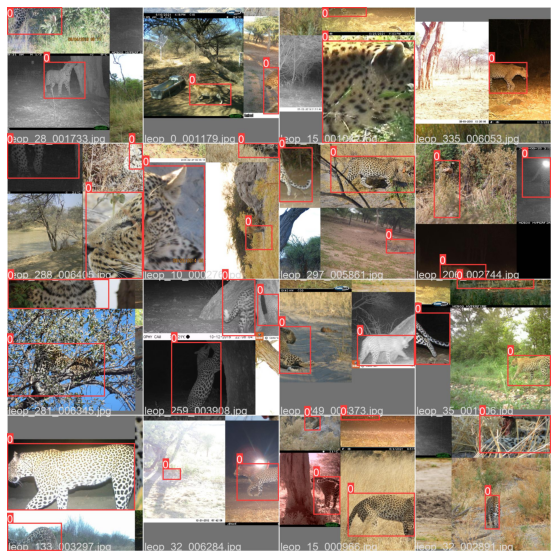

In [ ]:
image = cv2.imread(WDIR+'/yolov5/runs/train/det-no-augmentation2/train_batch0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

visualize(image)

### Test without augmentation nor negatives

In [ ]:
# Run YOLOv5x on best weights
# This model has no augmentation and no negative images
BEST=WDIR+'/yolov5/runs/train/det-no-augmentation2/weights/best.pt'

!python val.py --weights $BEST --data $dataPath --img 640 --iou 0.65 --half --save-json --name "det-no-aug-no-neg"

val: data=/mydrive/MIDS/W210/Animal_Identification/yolov5/data/custom.yaml, weights=['/mydrive/MIDS/W210/Animal_Identification/yolov5/runs/train/det-no-augmentation2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=det-no-aug-no-neg, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 2022-6-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
val: Scanning '/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/dev/labels.cache' images and labels... 673 found, 0 missing, 0 empty, 0 corrupt: 100% 673/673 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 22/22 [01:06<00:00,  3.03s/it]
                 all        673        

# Detector with no augmentations and negatives images


In [ ]:
# model with no agumentations and with negative images
!python train.py --img 640 --batch 16 --epochs 150 --data $dataPath --weights yolov5s.pt --cache --hyp $hyp_aug --name "det-no-aug-with-neg"

train: weights=yolov5s.pt, cfg=, data=/mydrive/MIDS/W210/Animal_Identification/yolov5/data/custom.yaml, hyp=/mydrive/MIDS/W210/Animal_Identification/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=det-no-aug-with-neg, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2022-6-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.

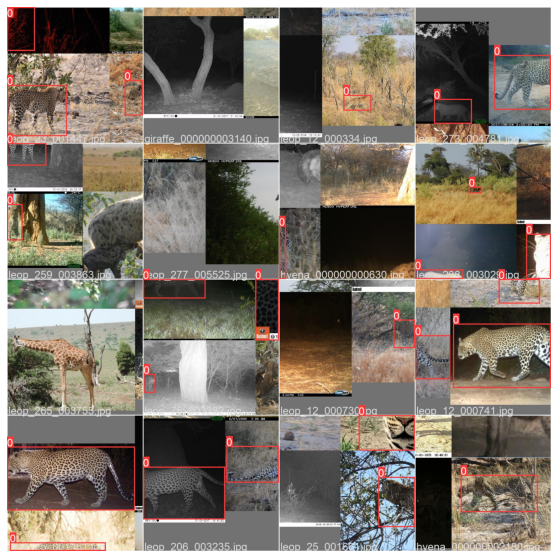

In [ ]:
image = cv2.imread(WDIR+'/yolov5/runs/train/det-no-aug-with-neg/train_batch0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

visualize(image)

### Test the model: No aug with neg

In [ ]:
# UPDATE!!!!
BEST=WDIR+'/yolov5/runs/train/det-no-aug-with-neg/weights/best.pt'

!python val.py --weights $BEST --data $dataPath --img 640 --iou 0.65 --half --save-json --name "det-no-aug-with-neg"

val: data=/mydrive/MIDS/W210/Animal_Identification/yolov5/data/custom.yaml, weights=['/mydrive/MIDS/W210/Animal_Identification/yolov5/runs/train/det-no-aug-with-neg/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=det-no-aug-with-neg, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 2022-6-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
100% 755k/755k [00:00<00:00, 53.6MB/s]
val: Scanning '/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/dev/labels.cache' images and labels... 905 found, 0 missing, 232 empty, 0 corrupt: 100% 905/905 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 29/29 [01:27<00:00,  3.03s/

# Detector with augmentations and negatives

Setup - Before running the script, the selected transformations were added to the `augmentations.py` file.

In [ ]:
LAST_WEIGHTS=WDIR+'/yolov5/runs/train/det-with-aug-and-neg17/weights/last.pt'

In [ ]:
!python train.py --img 416 --batch 16 --epochs 150 --data $dataPath --weights $LAST_WEIGHTS --hyp $hyp_aug --name "det-with-def-aug-and-neg"

train: weights=/mydrive/MIDS/W210/Animal_Identification/yolov5/runs/train/det-with-aug-and-neg17/weights/last.pt, cfg=, data=/mydrive/MIDS/W210/Animal_Identification/yolov5/data/custom.yaml, hyp=/mydrive/MIDS/W210/Animal_Identification/yolov5/data/hyps/hyp.scratch-med.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=det-with-def-aug-and-neg, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2022-6-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: l

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Afngm1a3ZOCh8R7Og8bb")
project = rf.workspace("leopardid").project("leopard_h_f_270-tonkj")
dataset = project.version(2).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 6.7 MB/s 
     |████████████████████████████████| 178 kB 67.3 MB/s 
     |████████████████████████████████| 3.1 MB 63.2 MB/s 
     |████████████████████████████████| 1.1 MB 59.8 MB/s 
     |████████████████████████████████| 21.8 MB 1.3 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 138 kB 73.0 MB/s 
     |████████████████████████████████| 596 kB 66.7 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.7-py3-none-any.whl size=24049 sha256=e9cfe1042795da3deaa6ad7c0c4399dbe01d77ddea08f2fac2043b7ef599e9db
  Stored in directory: /root/.cache/pip/wheels/e6/e3/d6/a142059abb9cc856d3c499a9f6f354d6bcd34ba971addce12b
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to leopard_h_f_270-2 in yolov5pytorch:: 100%|██████████| 14056/14056 [00:13<00:00, 1077.07it/s]


In [ ]:
LAST_WEIGHTS='/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/yolov5/runs/train/det-with-def-aug-roboflow-v27/weights/last.pt'

In [ ]:
# Roboflow model - repeat
!python train.py --img 416 --batch 16 --epochs 150 --data $dataPath --weights $LAST_WEIGHTS --name "det-with-def-aug-roboflow-v2" --cache

train: weights=/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/yolov5/runs/train/det-with-def-aug-roboflow-v27/weights/last.pt, cfg=, data=/content/leopard_h_f_270-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=det-with-def-aug-roboflow-v2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2022-6-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0

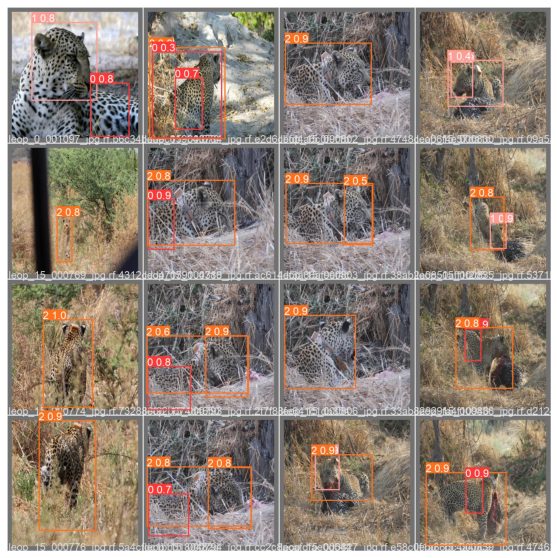

In [ ]:
image = cv2.imread(WDIR+'/yolov5/runs/train/det-with-def-aug-roboflow-v28/val_batch0_pred.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

visualize(image)

## Evaluation with roboflow 270 set

In [ ]:
# UPDATE!!!!# UPDATE!!!!
BEST=WDIR+'/yolov5/runs/train/det-with-def-aug-roboflow-v28/weights/best.pt'

!python val.py --weights $BEST --data $dataPath --img 416 --iou 0.4 --half --save-json --name "det-with-def-aug-roboflow-v2"

val: data=/content/leopard_h_f_270-2/data.yaml, weights=['/mydrive/MIDS/W210/Animal_Identification/yolov5/runs/train/det-with-def-aug-roboflow-v28/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.4, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=det-with-def-aug-roboflow-v2, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 2022-6-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients
val: Scanning '/content/leopard_h_f_270-2/valid/labels.cache' images and labels... 268 found, 0 missing, 0 empty, 0 corrupt: 100% 268/268 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 9/9 [00:05<00:00,  1.77it/s]
                 all        268        528      0.931      0.907      0.958      0.593
      

# Train 270 with Augmentation and NI

In [13]:
%cd /content/

/content


In [14]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Afngm1a3ZOCh8R7Og8bb")
project = rf.workspace("leopardid").project("leopard_h_f_270-tonkj")
dataset = project.version(3).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to leopard_h_f_270-3 in yolov5pytorch:: 100%|██████████| 15392/15392 [00:13<00:00, 1106.98it/s]


In [15]:
dataPath='/content/leopard_h_f_270-3/data.yaml'

In [12]:
# Roboflow model - repeat
!python train.py --img 416 --batch 16 --epochs 150 --data $dataPath --weights yolov5s.pt --name "det-with-def-aug-ni-roboflow-v3" --cache

train: weights=yolov5s.pt, cfg=, data=/content/leopard_h_f_270-3/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=det-with-def-aug-ni-roboflow-v3, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2022-6-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, o

### Evaluation of MC+NI+A

In [18]:
# UPDATE!!!!# UPDATE!!!!
BEST=WDIR+'/yolov5/runs/train/det-with-def-aug-ni-roboflow-v32/weights/best.pt'

!python val.py --weights $BEST --data $dataPath --img 416 --iou 0.65 --half --save-json --name "det-with-def-aug--ni-roboflow-v3"

val: data=/content/leopard_h_f_270-3/data.yaml, weights=['/mydrive/MIDS/W210/Animal_Identification/yolov5/runs/train/det-with-def-aug-ni-roboflow-v32/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.65, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=det-with-def-aug--ni-roboflow-v3, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 2022-6-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7026307 parameters, 0 gradients
100% 755k/755k [00:00<00:00, 18.8MB/s]
val: Scanning '/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/yolov5/leopard_h_f_270-3/valid/labels' images and labels...293 found, 0 missing, 25 empty, 0 corrupt: 100% 293/293 [00:01<00:00, 237.48it/s]
val: New cache created: /content/gdrive/MyDrive/MIDS/W210/Animal_Identification/yolov5/leopard_h_f_270-3/valid/